In [14]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

In [163]:
TRACKING_LMPC = "tracking_mpc"
TV_LMPC = "naive_ltv_lmpc"
LBLMPC = "lblmpc"
LOCAL_LMPC = "local_ltv_lmpc"
TRUE_LMPC = "true_ltv_lmpc"
LTI_LMPC = "lti_lmpc"
TUBE_LMPC = "tube_ltv_lmpc"
controllers = [TRACKING_LMPC, TV_LMPC, LBLMPC, LOCAL_LMPC, TRUE_LMPC, TUBE_LMPC]
save_dir = "dubin_car_expts_2/"

In [164]:
data = {controller:experiment_utils.load_results(save_dir, controller) for controller in controllers}

In [165]:
def compute_iteration_costs(data):
    iteration_costs = [q[0] for q in data["value_funcs"]]
    return iteration_costs
    
iteration_costs = [np.vstack(compute_iteration_costs(experiment) for experiment in data[controller]) for controller in controllers[1:]]

# iteration_costs = [np.vstack((compute_iteration_costs(data[controller][-1]),compute_iteration_costs(data[controller][-2]), compute_iteration_costs(data[controller][-3]))) for controller in controllers[1:]]

C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [166]:
def plot_with_bars_qts(x, alpha=0.3, lw=4, linestyle="o-"):
    q2 = np.quantile(x, 0.5, axis=0)
    q1 = np.quantile(x, 0.25, axis=0)
    q3 = np.quantile(x, 0.75, axis=0)
    plt.fill_between(np.arange(x.shape[1]), q1, q3, alpha=alpha)
    plt.plot(q2, linestyle, lw=lw)
    

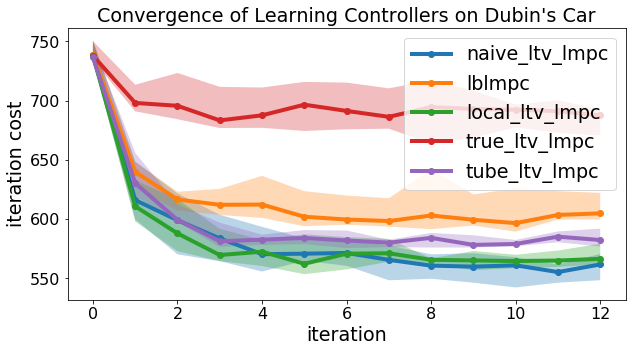

In [167]:
colors = ["r", "g","b","c","m","y","k"]
plt.figure(figsize=(10,5))
for iteration_cost,c in zip(iteration_costs, colors):
    plot_with_bars_qts(iteration_cost[:,9:-3])
plt.legend(controllers[1:],loc="upper right")
plt.xlabel("iteration")
plt.ylabel("iteration cost")
plt.title("Convergence of Learning Controllers on Dubin's Car")
plt.savefig(save_dir + "converge_quartiles.png")

In [183]:
delta_lim = np.pi / 6
a_lim = 0.3
vlims = [-.1, 1]
n = 100
dt = 0.1
init_input_trajs = [d["u_trajs"] for d in data[TRACKING_LMPC]]
local_input_trajs = [d["u_trajs"] for d in data[LOCAL_LMPC]]
init_x_trajs = [d["x_trajs"] for d in data[TRACKING_LMPC]]
local_x_trajs = [d["x_trajs"] for d in data[LOCAL_LMPC]]

init_a_trajs, init_delta_trajs = zip(*[(u_traj[-1][:,0], u_traj[-1][:,1]) for u_traj in init_input_trajs])
a_trajs, delta_trajs = zip(*[(u_traj[-1][0,:], u_traj[-1][1,:]) for u_traj in local_input_trajs])
init_v_trajs = [x_traj[-1][:,3] for x_traj in init_x_trajs]
v_trajs = [x_traj[-1][3,:] for x_traj in local_x_trajs]
init_a_trajs = np.vstack(init_a_trajs)
a_trajs = np.vstack(a_trajs)
init_delta_trajs = np.vstack(init_delta_trajs)
delta_trajs = np.vstack(delta_trajs)
init_v_trajs = np.vstack(init_v_trajs)
v_trajs = np.vstack(v_trajs)

In [184]:
def plot_with_bars_qts(ax, x, y, alpha=0.3, lw=4, linestyle="o-", label=""):
    q2 = np.quantile(y, 0.5, axis=0)
    q1 = np.quantile(y, 0.25, axis=0)
    q3 = np.quantile(y, 0.75, axis=0)
    ax.fill_between(x, q1, q3, alpha=alpha, label=label)
    ax.plot(x, q2, linestyle, lw=lw, label=label)
    

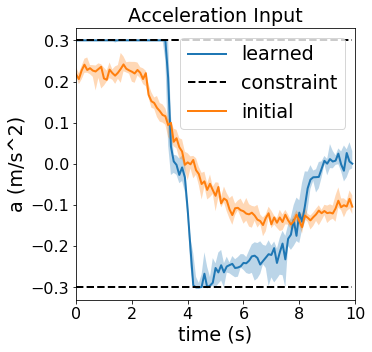

In [199]:
lw=2
ts = np.arange(n) * dt
figsize = (5,5)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_with_bars_qts(ax, ts, a_trajs, lw=lw, linestyle="-", label="learned")
plot_with_bars_qts(ax, ts, init_a_trajs, lw=lw, linestyle="-", label="initial")
ax.plot(ts, [-a_lim] * n, "k--", label="constraint", lw=lw)
ax.plot(ts, [a_lim] * n, "k--", label="constraint", lw=lw)
ax.set_xlabel("time (s)")
ax.set_ylabel("a (m/s^2)")
ax.set_xlim((0,10))
handles, labels = ax.get_legend_handles_labels()
idx = [0,3,1]
handles = [handles[i] for i in idx]
labels = [labels[i] for i in idx]
plt.legend(handles, labels, loc="upper right")
plt.title("Acceleration Input")
plt.savefig(save_dir + "local_accelerations.png",bbox_inches="tight")

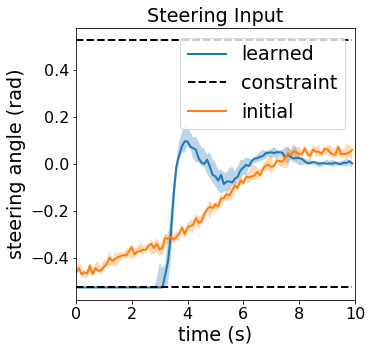

In [198]:
lw=2
ts = np.arange(n) * dt
figsize = (5,5)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_with_bars_qts(ax, ts, delta_trajs, lw=lw, linestyle="-", label="learned")
plot_with_bars_qts(ax, ts, init_delta_trajs, lw=lw, linestyle="-", label="initial")
ax.plot(ts, [-delta_lim] * n, "k--", label="constraint", lw=lw)
ax.plot(ts, [delta_lim] * n, "k--", label="constraint", lw=lw)
ax.set_xlabel("time (s)")
ax.set_ylabel("steering angle (rad)")
ax.set_xlim((0,10))
handles, labels = ax.get_legend_handles_labels()
idx = [0,3,1]
handles = [handles[i] for i in idx]
labels = [labels[i] for i in idx]
plt.legend(handles, labels, loc="upper right")
plt.title("Steering Input")
plt.savefig(save_dir + "local_steering.png",bbox_inches="tight")

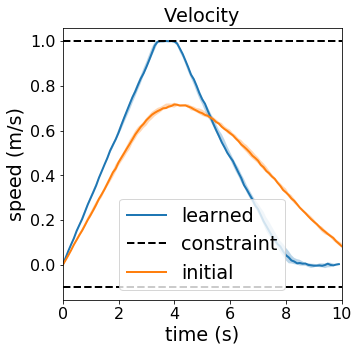

In [197]:
lw=2
ts = np.arange(n+1) * dt
figsize = (5,5)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_with_bars_qts(ax, ts[:-1], v_trajs, lw=lw, linestyle="-", label="learned")
plot_with_bars_qts(ax, ts, init_v_trajs, lw=lw, linestyle="-", label="initial")
ax.plot(ts, [vlims[0]] * (n+1), "k--", label="constraint", lw=lw)
ax.plot(ts, [vlims[1]] * (n+1), "k--", label="constraint", lw=lw)
ax.set_xlabel("time (s)")
ax.set_ylabel("speed (m/s)")
ax.set_xlim((0,10))
handles, labels = ax.get_legend_handles_labels()
idx = [0,3,1]
handles = [handles[i] for i in idx]
labels = [labels[i] for i in idx]
plt.legend(handles, labels, loc="lower center")
plt.title("Velocity")
plt.savefig(save_dir + "local_speed.png", bbox_inches="tight")